<a href="https://colab.research.google.com/github/tanmana5/mangrove-diaries/blob/main/Mangrove_and_Coral_Reef_Interaction_Model_(Updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

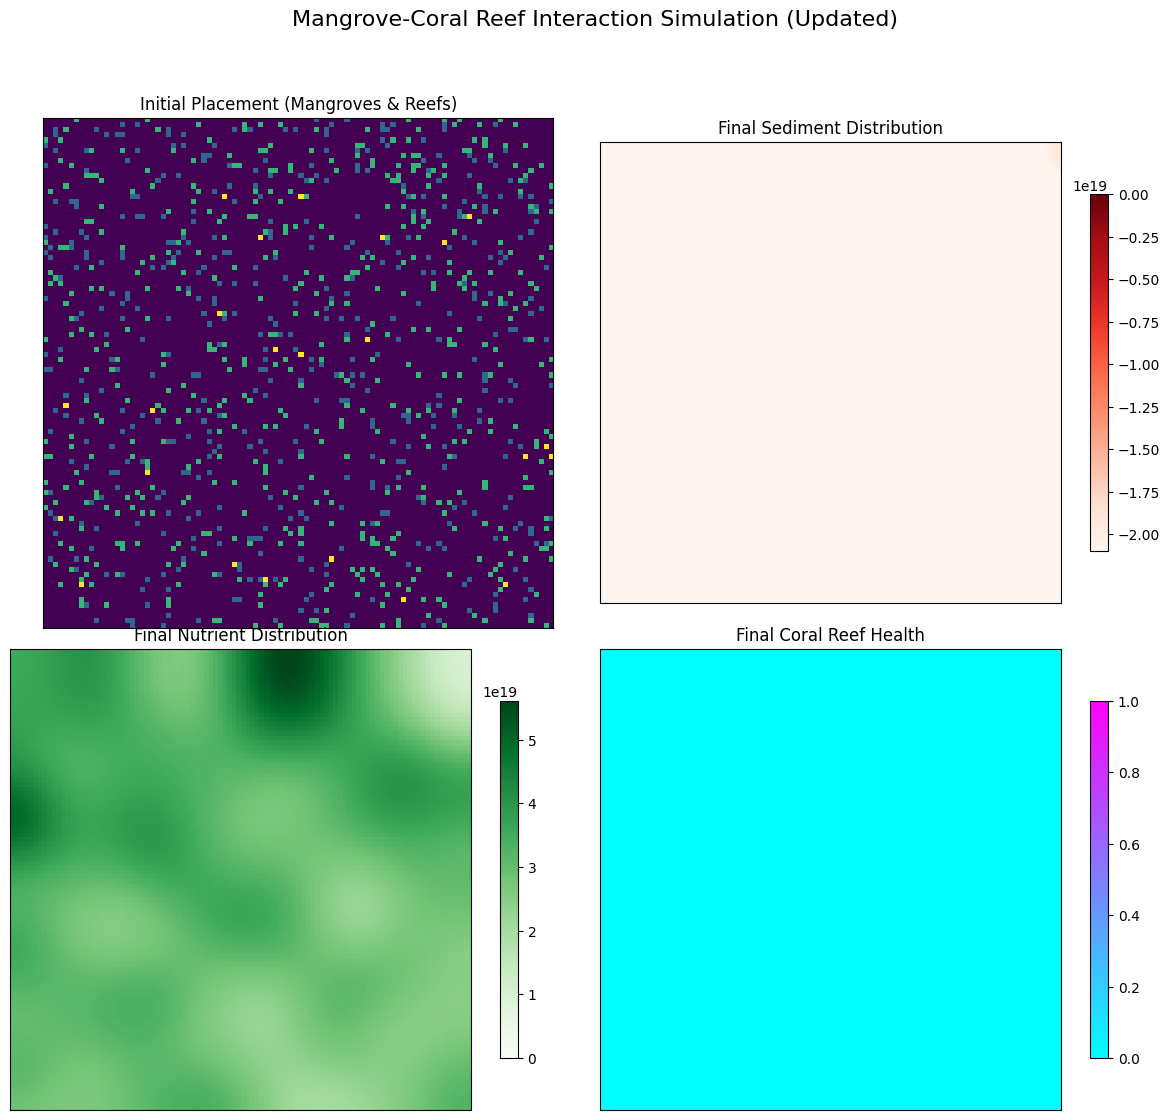

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# --- Constants and Model Parameters ---
# Feel free to adjust these values to see how the model changes.
GRID_SIZE = 100
SIMULATION_STEPS = 200  # Increased steps to see long-term effects
MANGROVE_DENSITY = 0.05
REEF_DENSITY = 0.05

# Interaction parameters
MANGROVE_SEDIMENT_OUTPUT = -0.1
MANGROVE_NUTRIENT_OUTPUT = 0.05

# Coral reef health parameters
CORAL_SEDIMENT_SENSITIVITY = 0.5
CORAL_NUTRIENT_OPTIMAL = 0.1
CORAL_NUTRIENT_SENSITIVITY = 0.3

# --- New Parameters for Tidal Flow and Climate Change ---
TIDAL_STRENGTH = 0.2  # The strength of the directional flow
CLIMATE_CHANGE_DAMAGE_RATE = 0.0005 # The gradual damage to coral health per step

# Diffusion kernel for spreading effects (a simple 3x3 average)
DIFFUSION_KERNEL = np.array([[0.05, 0.1, 0.05],
                             [0.1,  0.4, 0.1],
                             [0.05, 0.1, 0.05]])

# A kernel for tidal flow (biases movement to the right)
# This will be flipped to simulate the "ebb and flow"
TIDAL_FLOW_KERNEL = np.array([[0, 0, 0],
                              [0, 1, 0],
                              [0, 0.2, 0.2]])


def initialize_grid(size):
    """
    Initializes the grids for the simulation.
    Returns:
        mangroves, reefs, sediment, nutrients, coral_health
    """
    # Create an empty grid
    mangroves = np.zeros((size, size))
    reefs = np.zeros((size, size))

    # Randomly place mangroves and reefs
    mangrove_locs = np.random.rand(size, size) < MANGROVE_DENSITY
    mangroves[mangrove_locs] = 1

    reef_locs = np.random.rand(size, size) < REEF_DENSITY
    reefs[reef_locs] = 1

    # Initialize environmental and health grids
    sediment = np.zeros((size, size))
    nutrients = np.zeros((size, size))
    coral_health = reefs.copy()

    return mangroves, reefs, sediment, nutrients, coral_health


def run_simulation(mangroves, reefs, sediment, nutrients, coral_health, steps):
    """
    Runs the simulation loop for a specified number of steps.
    """
    for step in range(steps):
        # 1. Mangrove effects: Apply direct effects on sediment and nutrients
        sediment += mangroves * MANGROVE_SEDIMENT_OUTPUT
        nutrients += mangroves * MANGROVE_NUTRIENT_OUTPUT

        # 2. Diffusion and Tidal Flow: Spread the effects across the grid
        # The direction of the tide flips every 50 steps
        if (step // 50) % 2 == 0:
            # Flowing to the right
            flow_kernel = TIDAL_FLOW_KERNEL
        else:
            # Flowing to the left
            flow_kernel = np.fliplr(TIDAL_FLOW_KERNEL)

        # Combine normal diffusion with tidal flow
        sediment = convolve(sediment, DIFFUSION_KERNEL + flow_kernel * TIDAL_STRENGTH, mode='reflect')
        nutrients = convolve(nutrients, DIFFUSION_KERNEL + flow_kernel * TIDAL_STRENGTH, mode='reflect')

        # 3. Coral reef health update:
        # Coral health declines with high sediment.
        sediment_damage = CORAL_SEDIMENT_SENSITIVITY * np.maximum(0, sediment)

        # Coral health is affected by nutrient levels away from the optimal.
        nutrient_damage = CORAL_NUTRIENT_SENSITIVITY * (nutrients - CORAL_NUTRIENT_OPTIMAL)**2

        # New: Add a constant, cumulative damage from climate change
        climate_change_damage = step * CLIMATE_CHANGE_DAMAGE_RATE

        # Combine effects and apply to coral health, ensuring it stays between 0 and 1.
        coral_health -= (sediment_damage + nutrient_damage + climate_change_damage) * reefs
        coral_health = np.clip(coral_health, 0, 1)

    return coral_health, sediment, nutrients


def plot_results(mangroves, reefs, final_coral_health, final_sediment, final_nutrients):
    """
    Visualizes the initial state and final results of the simulation.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    plt.suptitle("Mangrove-Coral Reef Interaction Simulation (Updated)", fontsize=16)

    # Plot 1: Initial State (Mangroves and Reefs)
    axes[0, 0].imshow(mangroves + reefs * 2, cmap='viridis')
    axes[0, 0].set_title("Initial Placement (Mangroves & Reefs)")
    axes[0, 0].set_xticks([])
    axes[0, 0].set_yticks([])

    # Plot 2: Final Sediment Distribution
    sediment_plot = axes[0, 1].imshow(final_sediment, cmap='Reds', vmin=0)
    axes[0, 1].set_title("Final Sediment Distribution")
    axes[0, 1].set_xticks([])
    axes[0, 1].set_yticks([])
    fig.colorbar(sediment_plot, ax=axes[0, 1], shrink=0.7)

    # Plot 3: Final Nutrient Distribution
    nutrient_plot = axes[1, 0].imshow(final_nutrients, cmap='Greens', vmin=0)
    axes[1, 0].set_title("Final Nutrient Distribution")
    axes[1, 0].set_xticks([])
    axes[1, 0].set_yticks([])
    fig.colorbar(nutrient_plot, ax=axes[1, 0], shrink=0.7)

    # Plot 4: Final Coral Reef Health
    health_plot = axes[1, 1].imshow(final_coral_health, cmap='cool', vmin=0, vmax=1)
    axes[1, 1].set_title("Final Coral Reef Health")
    axes[1, 1].set_xticks([])
    axes[1, 1].set_yticks([])
    fig.colorbar(health_plot, ax=axes[1, 1], shrink=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


if __name__ == "__main__":
    # Initialize the grids
    mangroves, reefs, sediment, nutrients, coral_health = initialize_grid(GRID_SIZE)

    # Run the simulation
    final_coral_health, final_sediment, final_nutrients = run_simulation(
        mangroves, reefs, sediment, nutrients, coral_health, SIMULATION_STEPS
    )

    # Plot the results
    plot_results(mangroves, reefs, final_coral_health, final_sediment, final_nutrients)